# Some functionalities and timings

### Preamble

This notebook introduces some functionalities of the package and gives an idea about run times.

### Initialize Ray

We use the `ray` package a lot. So we start off by initializing an instance of ray. Note the `num_cpus` argument, which should be adapted for your machine.

In [ ]:
import ray
ray.init(
    num_cpus=16,
    #_temp_dir="/scratch/wulsdorf/scratch"
)

### Load the dataset

Next, we load the dataset. This is a set of alkane molecules, kindly provided by Trevor Gokey.

The systems are stored in a `systemmanager` instance, which is simple datastructure to store different systems and their associated target data.

In [ ]:
import pickle
from BayesTyper import system
from BayesTyper import tools

with open("./AlkaneSet/opt-training-1.pickle", "rb") as fopen:
    optdataset_dict = pickle.load(fopen)

systemmanager = system.SystemManager()
tools.generate_systemmanager(
    list(
        optdataset_dict.keys()
    ),
    systemmanager,
    optdataset_dict=optdataset_dict,
    torsiondataset_dict=None,
    weight_geo = 1.,
    weight_vib = 0,
    weight_offeq = 0,
    weight_torsion = 0,
    weight_force = 0.1,
    add_units=True,
    ene_weighting=True,
    force_projection=False,
)

### Overview dataset

Let's have a closer look at how many targets are in the dataset

In [ ]:
from BayesTyper import targets

N_optgeo = 0
N_forces = 0
N_systems = 0
for sys in systemmanager.get_systems():
    for tg in sys.target_list:
        if isinstance(tg, targets.GeoTarget):
            N_optgeo += tg.target_strcs.shape[0]
        if isinstance(tg, targets.ForceMatchingTarget):
            N_forces += tg.target_strcs.shape[0]   
    N_systems += 1
    
print(
    "Dataset overview:\n",
    f"\t {N_systems} systems \n",
    f"\t {N_optgeo} optgeo targets \n",
    f"\t {N_forces} force matching targets",
)

### Generate bond and angle vectors

Next, we will generate useful high-level parameter vector objects that we can use to manipulate the parameters in the systems objects. We will create one parameter vector for bond forces and one for angle forces. Note that the parameter vectors expose only a linear mapping to the actual parameter vectors (very much in the sense that ForceBalance treats parameter values).

In [ ]:
from BayesTyper import parameters
from BayesTyper import vectors

bond_mngr = parameters.BondManager()
bond_mngr.add_system_manager(systemmanager)

angle_mngr = parameters.AngleManager()
angle_mngr.add_system_manager(systemmanager)

pvec_bonds  = vectors.ForceFieldParameterVector(bond_mngr)
pvec_angles = vectors.ForceFieldParameterVector(angle_mngr)

### Generate some timings

Next, we want to benchmark some timings of the `LikelihoodVectorized` class. With this class, we can retrieve the log-Likelihood and its gradient easily. In the background, it will process the individual systems in batches. The size of each batch must be defined using `N_sys_per_batch`.

In [ ]:
from BayesTyper import likelihoods
from BayesTyper import targets
import numpy as np
import time

func_timings = np.zeros((10,10), dtype=float)
grad_timings = np.zeros((10,10), dtype=float)
for i, N_sys_per_batch in enumerate(range(1,21,2)):
    print(
        f"Probing N_sys_per_batch={N_sys_per_batch}"
    )
    logL = likelihoods.LikelihoodVectorized(
        [pvec_bonds, pvec_angles],
        targets.TargetComputer(systemmanager),
        N_sys_per_batch=N_sys_per_batch,
        three_point=False,
    )
    x = logL.pvec[:]
    for j in range(10):
        start_time = time.time()
        _ = logL(x)
        delta_time = time.time() - start_time
        func_timings[i, j] = delta_time

        start_time = time.time()
        _ = logL.grad(x)
        delta_time = time.time() - start_time
        grad_timings[i, j] = delta_time

### Various timings for different setups

Below you can find various plots evaluating the function and gradient performance for various choices of `N_sys_per_batch` and number of processors available to `ray`. 

We can see that if the number of systems is much higher than the number of available cores, it is good to use a high `N_sys_per_batch`. If a high number of cores is available, `N_sys_per_batch=3` is usually a good choice.

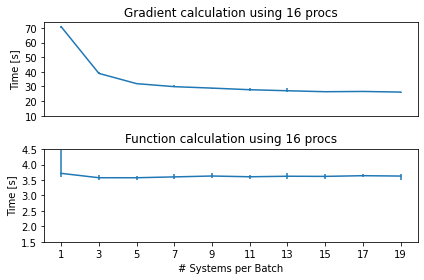

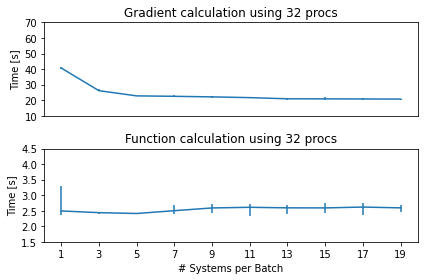

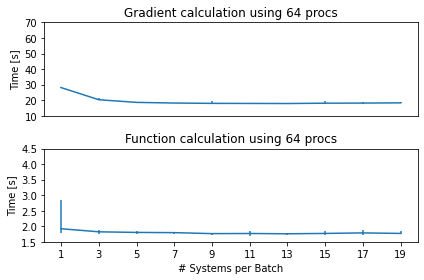

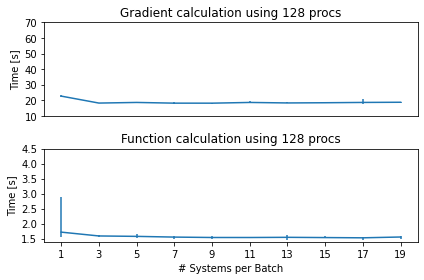

In [24]:
import matplotlib.pyplot as plt

for nprocs in [16,32,64,128]:
    
    grad_timings = np.load(f"./grad-timings-{nprocs:d}procs.npy")
    func_timings = np.load(f"./func-timings-{nprocs:d}procs.npy")

    fig, axs = plt.subplots(2, sharex="row")

    axs[0].errorbar(
        y=grad_timings.mean(axis=1),
        x=range(1,21,2),
        yerr=[
            grad_timings.mean(axis=1)-grad_timings.min(axis=1),
            grad_timings.max(axis=1)-grad_timings.mean(axis=1),
        ],
    )
    axs[0].set_xticks([])
    axs[0].set_yticks(np.arange(10,80,10))
    axs[0].set_ylabel("Time [s]")
    axs[0].set_title(f"Gradient calculation using {nprocs} procs")

    axs[1].errorbar(
        y=func_timings.mean(axis=1),
        x=range(1,21,2),
        yerr=(
            func_timings.mean(axis=1)-func_timings.min(axis=1),
            func_timings.max(axis=1)-func_timings.mean(axis=1)
        ),
    )
    axs[1].set_xticks(range(1,21,2))
    axs[1].set_yticks(np.arange(1.5,5.0,0.5))
    axs[1].set_ylabel("Time [s]")
    axs[1].set_xlabel("# Systems per Batch")
    axs[1].set_title(f"Function calculation using {nprocs} procs")

    fig.tight_layout()
    fig.savefig("./benchmark-16procs.png")
    fig.show()